# Implementation to consider sample intervals

## Imports

In [57]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.visual import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import LEG_CONTAMINATION_LEV
from utils.config import DEFAULT_LITHO_LEXICON, DEFAULT_LITHO_LEGEND, DEFAULT_POL_LEXICON
from utils.io import dataframe_viewer, dict_viewer
from utils.orm import boreholes_from_dataframe
from utils.visual import legend_from_attributes
from core.project import Project
from core.orm import BoreholeOrm, PositionOrm, Base 

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
df = pd.read_csv('real_data_subset_for_test.csv', sep=',')

In [60]:
df['ID'].dtype

KeyError: 1

In [3]:
dataframe_viewer(df, rows=5, un_val='ID')

Rows : 112, columns : 19, Unique values on col 'ID': 46


interactive(children=(IntSlider(value=5, description='rows', max=112, min=5, readout=False), IntSlider(value=1…

In [4]:
df_litho = df[['ID', 'X', 'Y', 'Z', 'Long_for', 'Litho_top', 'Litho_base', 'Epais_intv', 'Lithology']]
df_litho.rename(columns={'Lithology':'Description'}, inplace=True)

df_ech = df[['ID', 'X', 'Y', 'Z', 'Long_for', 'ID_ech', 'Type_ech', 'Top_intv', 'Base_intv', 
             'Epais_intv', 'Bnz', 'Toln', 'Pb', 'As', 'Cu', 'Ni']]
df_ech.rename(columns={'Top_intv':'Ech_top', 'Base_intv':'Ech_base'}, inplace=True)

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
pollutants = []
for i, c in enumerate(df.columns):
    if c in DEFAULT_POL_LEXICON.abbreviations.keys() or c in DEFAULT_POL_LEXICON.abbreviations.values():
        print(f"{i}: {c}")
        pollutants.append(c)

13: Bnz
14: Toln
15: Pb
16: As
17: Cu
18: Ni


In [6]:
bh_id='201'
dataframe_viewer(df_litho.query(f"ID=='{bh_id}'"), rows=3, cols=16), dataframe_viewer(df_ech.query(f"ID=='{bh_id}'"), rows=3, cols=16)

Rows : 2, columns : 9


interactive(children=(IntSlider(value=2, description='rows', max=2, min=2, readout=False), IntSlider(value=9, …

Rows : 2, columns : 16


interactive(children=(IntSlider(value=2, description='rows', max=2, min=2, readout=False), IntSlider(value=16,…

(None, None)

In [7]:
# adds a description in sample (TEST)
df_ech['Description'] = np.nan
df_ech.loc[:1, 'Description'] = ['Sable', 'Limon']

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Create Boreholes from dataframes

In [8]:
data_dict = {'lithologies_data': df_litho, 'pollutants_data': df_ech}

In [9]:
boreholes, components, link_intv_comp = boreholes_from_dataframe(data_dict, verbose=False,
                                                sample_type_col='Type_ech', diameter_col='Diam_for', 
                                                average_z=102, attributes=['lithology']+pollutants, 
                                                symbols={'lithology':{'lexicon':DEFAULT_LITHO_LEXICON}})


Data Processing...
To continue, default diameter column has been created with value: 0.1 [m]

 BH_ID: '201'
0- Interval top=0.6, base=1.2, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

1- Interval top=0.6, base=1.2, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

2- Interval top=0.7, base=1.2, type=sample
 - Interval components: [Component({'lithology': 'sable'}), Component({'benzène': 'vi', 'concentration': 0.72, 'unit': 'mg/kg MS'}), Component({'toluène': 'vs', 'concentration': 0.59, 'unit': 'mg/kg MS'}), Component({'plomb': 'vs', 'concentration': 79.0, 'unit': 'mg/kg MS'}), Component({'arsenic': 'vr', 'concentration': 11.0, 'unit': 'mg/kg MS'}), Component({'cuivre': 'vs', 'concentration': 21.0, 'unit': 'mg/kg MS'}), Component({'nickel': 'vs', 'concentration': 90.0, 'unit': 'mg/kg MS'})]

3- Interval top=2.0, base=2.4, type=sample
 - Interval components: [Component({'lithology': 'limon'}), Component({'benzène': 'vs', 'c

/home/yanathan/Projects/GSDMA/utils/orm.py:208: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship.
  boreholes_orm.append(BoreholeOrm(id=bh_name, date=bh_date))
/home/yanathan/Projects/GSDMA/utils/orm.py:208: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.intv_id, which conflic


 - Interval components: [Component({'lithology': 'boue'})]

2- Interval top=0.0, base=0.2, type=lithology
 - Interval components: [Component({'lithology': 'boue'})]

3- Interval top=0.0, base=0.2, type=lithology
 - Interval components: [Component({'lithology': 'boue'})]

4- Interval top=0.2, base=0.6, type=sample
 - Interval components: [Component({'benzène': 'vi', 'concentration': 0.69, 'unit': 'mg/kg MS'}), Component({'toluène': 'vs', 'concentration': 0.47, 'unit': 'mg/kg MS'}), Component({'plomb': 'vs', 'concentration': 94.0, 'unit': 'mg/kg MS'}), Component({'arsenic': 'vs', 'concentration': 18.0, 'unit': 'mg/kg MS'}), Component({'cuivre': 'vs', 'concentration': 37.0, 'unit': 'mg/kg MS'}), Component({'nickel': 'vi', 'concentration': 280.0, 'unit': 'mg/kg MS'})]

5- Interval top=1.9, base=2.4, type=sample
 - Interval components: [Component({'benzène': 'vi_', 'concentration': 3.1, 'unit': 'mg/kg MS'}), Component({'toluène': 'vs', 'concentration': 1.5, 'unit': 'mg/kg MS'}), Component(

 - Interval components: [Component({'benzène': 'vi', 'concentration': 0.54, 'unit': 'mg/kg MS'}), Component({'toluène': 'vs', 'concentration': 0.22, 'unit': 'mg/kg MS'}), Component({'plomb': 'vs', 'concentration': 190.0, 'unit': 'mg/kg MS'}), Component({'arsenic': 'vs', 'concentration': 20.0, 'unit': 'mg/kg MS'}), Component({'cuivre': 'vs', 'concentration': 23.0, 'unit': 'mg/kg MS'}), Component({'nickel': 'vs', 'concentration': 29.0, 'unit': 'mg/kg MS'})]

6- Interval top=3.2, base=3.4, type=sample
 - Interval components: [Component({'benzène': 'vi_', 'concentration': 0.84, 'unit': 'mg/kg MS'}), Component({'toluène': 'vr', 'concentration': 0.12, 'unit': 'mg/kg MS'}), Component({'plomb': 'vs', 'concentration': 99.0, 'unit': 'mg/kg MS'}), Component({'arsenic': 'vr', 'concentration': 10.0, 'unit': 'mg/kg MS'}), Component({'cuivre': 'vr', 'concentration': 12.0, 'unit': 'mg/kg MS'}), Component({'nickel': 'vr', 'concentration': 19.0, 'unit': 'mg/kg MS'})]

7- Interval top=4.4, base=4.8, type

0- Interval top=0.0, base=1.0, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

1- Interval top=0.0, base=1.0, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

2- Interval top=0.0, base=1.0, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

3- Interval top=0.0, base=1.0, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

4- Interval top=0.6, base=1.0, type=sample
 - Interval components: [Component({'benzène': 'vi_', 'concentration': 1.5, 'unit': 'mg/kg MS'}), Component({'toluène': 'vs', 'concentration': 1.0, 'unit': 'mg/kg MS'}), Component({'plomb': 'vs', 'concentration': 150.0, 'unit': 'mg/kg MS'}), Component({'arsenic': 'vs', 'concentration': 21.0, 'unit': 'mg/kg MS'}), Component({'cuivre': 'vs', 'concentration': 34.0, 'unit': 'mg/kg MS'}), Component({'nickel': 'vs', 'concentration': 55.0, 'unit': 'mg/kg MS'})]

5- Interval top=2.1, base=2.4, type=sample
 - Interval co

 Summary : {'F6M': {'lithology': Striplog(3 Intervals, start=0.0, stop=1.2), 'sample': Striplog(3 Intervals, start=0.0, stop=4.8)}}

 BH_ID: 'F12M'
0- Interval top=0.0, base=0.2, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

1- Interval top=0.0, base=0.3, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

2- Interval top=0.0, base=0.3, type=lithology
 - Interval components: [Component({'lithology': 'remblais'})]

3- Interval top=1.9, base=2.4, type=sample
 - Interval components: [Component({'benzène': 'vi', 'concentration': 0.69, 'unit': 'mg/kg MS'}), Component({'toluène': 'vr', 'concentration': 0.12, 'unit': 'mg/kg MS'}), Component({'plomb': 'vs', 'concentration': 280.0, 'unit': 'mg/kg MS'}), Component({'arsenic': 'vs', 'concentration': 22.0, 'unit': 'mg/kg MS'}), Component({'cuivre': 'vs', 'concentration': 50.0, 'unit': 'mg/kg MS'}), Component({'nickel': 'vs', 'concentration': 69.0, 'unit': 'mg/kg MS'})]

4- Interval top=0.

End of the process : 46 boreholes created successfully


In [10]:
len(boreholes), len(components)

(46, 13)

In [11]:
boreholes[0].intervals_values

{2: '{"lithology": "sable"}; {"benz\\u00e8ne": "vi", "concentration": 0.72, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vs", "concentration": 0.59, "unit": "mg/kg MS"}; {"plomb": "vs", "concentration": 79.0, "unit": "mg/kg MS"}; {"arsenic": "vr", "concentration": 11.0, "unit": "mg/kg MS"}; {"cuivre": "vs", "concentration": 21.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 90.0, "unit": "mg/kg MS"}', 3: '{"lithology": "limon"}; {"benz\\u00e8ne": "vs", "concentration": 0.12, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vr", "concentration": 0.15, "unit": "mg/kg MS"}; {"plomb": "vi", "concentration": 590.0, "unit": "mg/kg MS"}; {"arsenic": "vs", "concentration": 16.0, "unit": "mg/kg MS"}; {"cuivre": "vr", "concentration": 14.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 25.0, "unit": "mg/kg MS"}'}

In [12]:
boreholes[0].litho_intv_values

{0: {'interval_number': 0,
  'top': <core.orm.PositionOrm at 0x7f7f7acffa30>,
  'base': <core.orm.PositionOrm at 0x7f7f7ac19fa0>,
  'type': 'lithology',
  'description': '{"lithology": "remblais"}'},
 1: {'interval_number': 1,
  'top': <core.orm.PositionOrm at 0x7f7f7ab91160>,
  'base': <core.orm.PositionOrm at 0x7f7f7ab919a0>,
  'type': 'lithology',
  'description': '{"lithology": "remblais"}'}}

In [13]:
boreholes[0].sample_intv_values

{2: {'interval_number': 2,
  'top': <core.orm.PositionOrm at 0x7f7f7aafbaf0>,
  'base': <core.orm.PositionOrm at 0x7f7f7aafbb20>,
  'type': 'sample',
  'description': '{"lithology": "sable"}; {"benz\\u00e8ne": "vi", "concentration": 0.72, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vs", "concentration": 0.59, "unit": "mg/kg MS"}; {"plomb": "vs", "concentration": 79.0, "unit": "mg/kg MS"}; {"arsenic": "vr", "concentration": 11.0, "unit": "mg/kg MS"}; {"cuivre": "vs", "concentration": 21.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 90.0, "unit": "mg/kg MS"}'},
 3: {'interval_number': 3,
  'top': <core.orm.PositionOrm at 0x7f7f7aafbb50>,
  'base': <core.orm.PositionOrm at 0x7f7f7aafbbe0>,
  'type': 'sample',
  'description': '{"lithology": "limon"}; {"benz\\u00e8ne": "vs", "concentration": 0.12, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vr", "concentration": 0.15, "unit": "mg/kg MS"}; {"plomb": "vi", "concentration": 590.0, "unit": "mg/kg MS"}; {"arsenic": "vs", "concentration": 16

In [14]:
d1 = {'lithology': {0: {'interval_number': 0, 'top': 0, 'base': 1, 'type': 'lithology', 
                          'description': '{"lithology": "remblais"}'}, 
                      1: {'interval_number': 1, 'top': 1, 'base': 2, 'type': 'lithology', 
                          'description': '{"lithology": "sable"}'}},
     'sample': {0: {'interval_number': 0, 'top': 0, 'base': 1, 'type': 'sample', 
                          'description': '{"benzene": "VR"}'}, 
                      1: {'interval_number': 1, 'top': 1, 'base': 2, 'type': 'sample', 
                          'description': '{"Toluene": "VI"}'}}
     }

d2 = {0: {'interval_number': 0, 'top': 0, 'base': 1, 'type': 'lithology', 
          'description': '{"lithology": "remblais"}'}, 
      1: {'interval_number': 1, 'top': 1, 'base': 2, 'type': 'lithology', 
          'description': '{"lithology": "sable"}'}}

In [15]:
d = d1
keys = list(d.keys())
dict_viewer(d[keys[0]])

0,"{'interval_number': 0, 'top': 0, 'base': 1, 'type': 'lithology', 'description': '{""lithology"": ""remblais""}'}"
1,"{'interval_number': 1, 'top': 1, 'base': 2, 'type': 'lithology', 'description': '{""lithology"": ""sable""}'}"


In [16]:
def intv_func(d, attr=None):
    for k, v in d.items():
        if attr is None:
            print(k, v, '\n')
        else:
            if attr is not None and k==attr : print(k, v, '\n')

In [17]:
intv_func(d1, 'lithology')

lithology {0: {'interval_number': 0, 'top': 0, 'base': 1, 'type': 'lithology', 'description': '{"lithology": "remblais"}'}, 1: {'interval_number': 1, 'top': 1, 'base': 2, 'type': 'lithology', 'description': '{"lithology": "sable"}'}} 



In [18]:
s = lambda k, v: print(k, d[k])
s(keys[0], 0)

lithology {0: {'interval_number': 0, 'top': 0, 'base': 1, 'type': 'lithology', 'description': '{"lithology": "remblais"}'}, 1: {'interval_number': 1, 'top': 1, 'base': 2, 'type': 'lithology', 'description': '{"lithology": "sable"}'}}


In [19]:
boreholes

[<core.orm.BoreholeOrm>(Name=201, Length=1.7999999999999998, Diameter=0.1, Intervals=2),
 <core.orm.BoreholeOrm>(Name=205, Length=3.0, Diameter=0.1, Intervals=4),
 <core.orm.BoreholeOrm>(Name=208, Length=2.999999999999999, Diameter=0.1, Intervals=4),
 <core.orm.BoreholeOrm>(Name=207, Length=3.600000000000001, Diameter=0.1, Intervals=5),
 <core.orm.BoreholeOrm>(Name=212, Length=2.9999999999999982, Diameter=0.1, Intervals=4),
 <core.orm.BoreholeOrm>(Name=214, Length=3.399999999999999, Diameter=0.1, Intervals=4),
 <core.orm.BoreholeOrm>(Name=217, Length=3.000000000000001, Diameter=0.1, Intervals=4),
 <core.orm.BoreholeOrm>(Name=221, Length=0.8, Diameter=0.1, Intervals=1),
 <core.orm.BoreholeOrm>(Name=223, Length=1.6, Diameter=0.1, Intervals=2),
 <core.orm.BoreholeOrm>(Name=?2, Length=0.7999999999999998, Diameter=0.1, Intervals=1),
 <core.orm.BoreholeOrm>(Name=?1, Length=0.7999999999999998, Diameter=0.1, Intervals=1),
 <core.orm.BoreholeOrm>(Name=224, Length=1.0, Diameter=0.1, Intervals=1)

In [20]:
components

{0: Component({'type': 'lithology', 'value': 'remblai'}),
 1: Component({'type': 'lithology', 'value': 'sable'}),
 2: Component({'type': 'pollutant', 'value': 'benzène'}),
 3: Component({'type': 'pollutant', 'value': 'toluène'}),
 4: Component({'type': 'pollutant', 'value': 'plomb'}),
 5: Component({'type': 'pollutant', 'value': 'arsenic'}),
 6: Component({'type': 'pollutant', 'value': 'cuivre'}),
 7: Component({'type': 'pollutant', 'value': 'nickel'}),
 8: Component({'type': 'lithology', 'value': 'limon'}),
 9: Component({'type': 'lithology', 'value': 'boue'}),
 10: Component({'type': 'lithology', 'value': 'schiste'}),
 11: Component({'type': 'lithology', 'value': 'béton'}),
 12: Component({'type': 'lithology', 'value': 'alluvion'})}

In [21]:
i = 0
components[i][list(components[i].keys())[0]]#.json()

'lithology'

## Create a dictionary containing legends for each representation attribute

In [22]:
legend_dict = legend_from_attributes([('lithology', DEFAULT_LITHO_LEGEND)]+pollutants)

In [23]:
dict_viewer(legend_dict)

lithology,"{'legend': Legend(Decor({'_colour': '#ffffe9', 'width': None, 'hatch': None, 'component': Component({'lithology': 'matériau(?:x)? meuble(?:s)?'})}) Decor({'_colour': '#fff497', 'width': None, 'hatch': ""'....'"", 'component': Component({'lithology': 'alluvion'})}) Decor({'_colour': '#b54500', 'width': None, 'hatch': None, 'component': Component({'lithology': 'boue'})}) Decor({'_colour': '#d3b798', 'width': None, 'hatch': ""'v'"", 'component': Component({'lithology': 'remblai'})}) Decor({'_colour': '#a5c7c9', 'width': None, 'hatch': ""'t'"", 'component': Component({'lithology': 'b[é|e]ton'})}) Decor({'_colour': '#8da3c9', 'width': None, 'hatch': ""'t'"", 'component': Component({'lithology': 'scorie'})}) Decor({'_colour': '#ffcc99', 'width': None, 'hatch': None, 'component': Component({'lithology': 'tourbe'})}) Decor({'_colour': '#ffeaa7', 'width': None, 'hatch': None, 'component': Component({'lithology': 'gypse'})}) Decor({'_colour': '#00151a', 'width': None, 'hatch': None, 'component': Component({'lithology': 'houille'})}) Decor({'_colour': '#798732', 'width': None, 'hatch': ""'-.'"", 'component': Component({'lithology': 'limon'})}) Decor({'_colour': '#ffcb23', 'width': None, 'hatch': ""'..'"", 'component': Component({'lithology': 'sable'})}) Decor({'_colour': '#adb7cc', 'width': None, 'hatch': ""'oo"", 'component': Component({'lithology': 'gravier'})}) Decor({'_colour': '#ace4c8', 'width': None, 'hatch': None, 'component': Component({'lithology': 'silt'})}) Decor({'_colour': '#d5e6cc', 'width': None, 'hatch': ""'---'"", 'component': Component({'lithology': 'argile'})}) Decor({'_colour': '#92dcb7', 'width': None, 'hatch': None, 'component': Component({'lithology': 'bentonite'})}) Decor({'_colour': '#bbffdd', 'width': None, 'hatch': ""'--'"", 'component': Component({'lithology': 'schiste'})}) Decor({'_colour': '#95ffca', 'width': None, 'hatch': None, 'component': Component({'lithology': 'argilite'})}) Decor({'_colour': '#d6fe9a', 'width': None, 'hatch': None, 'component': Component({'lithology': 'siltite'})}) Decor({'_colour': '#e1f0d8', 'width': None, 'hatch': None, 'component': Component({'lithology': 'tuffeau'})}) Decor({'_colour': '#69cf9c', 'width': None, 'hatch': None, 'component': Component({'lithology': 'silex'})}) Decor({'_colour': '#b7d9cc', 'width': None, 'hatch': None, 'component': Component({'lithology': 'conglomérat'})}) Decor({'_colour': '#019ccd', 'width': None, 'hatch': None, 'component': Component({'lithology': 'carbonate'})}) Decor({'_colour': '#149eff', 'width': None, 'hatch': ""'='"", 'component': Component({'lithology': 'calcaire'})}) Decor({'_colour': '#fdaaff', 'width': None, 'hatch': None, 'component': Component({'lithology': 'dolomite'})}) Decor({'_colour': '#fdaffe', 'width': None, 'hatch': None, 'component': Component({'lithology': 'dolomie'})}) Decor({'_colour': '#deeffe', 'width': None, 'hatch': None, 'component': Component({'lithology': 'craie'})}) Decor({'_colour': '#aac2c8', 'width': None, 'hatch': None, 'component': Component({'lithology': 'chert'})}) Decor({'_colour': '#000000', 'width': None, 'hatch': None, 'component': Component({'lithology': 'charbon'})}) Decor({'_colour': '#7ba1a8', 'width': None, 'hatch': None, 'component': Component({'lithology': 'marne'})}) Decor({'_colour': '#ffffff', 'width': None, 'hatch': None, 'component': Component({'lithology': 'inconnu'})}) Decor({'_colour': '#ffffff', 'width': None, 'hatch': None, 'component': Component({'lithology': 'not_exist'})}))}"
benzène,"{'legend': Legend(Decor({'_colour': '#00ff00', 'width': None, 'component': Component({'benzène': 'vr'}), 'hatch': None}) Decor({'_colour': '#ffa500', 'width': None, 'component': Component({'benzène': 'vs'}), 'hatch': None}) Decor({'_colour': '#ff0000', 'width': None, 'component': Component({'benzène': 'vi'}), 'hatch': None}) Decor({'_colour': '#ffffff', 'width': None, 'component': Component({'benzène': 'inconnu'}), 'hatch': None}))}"
toluène,"{'legend': Legend(Decor({'_colour': '#00ff00', 'wid

## Create a project and save data in a database

In [24]:
DB_name = 'tmp_files/test_20211102_db.db'

if os.path.exists(DB_name):
    os.remove(DB_name)

engine = create_engine(f"sqlite:///{DB_name}", echo=True)

In [25]:
Base.metadata.create_all(engine)

2021-11-10 14:34:56,311 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-10 14:34:56,312 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-11-10 14:34:56,313 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-10 14:34:56,315 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-11-10 14:34:56,316 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-10 14:34:56,317 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-11-10 14:34:56,318 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-10 14:34:56,319 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-11-10 14:34:56,320 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-10 14:34:56,321 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Components")
2021-11-10 14:34:56,322 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-10 14:34:56,323 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Components")
2021-11-10 14:34:56,324 INFO sqlalchemy.engine.Engin

In [26]:
Session = sessionmaker(bind=engine)
session = Session()

#### Set project's legend dictionary

In [27]:
p = Project(session, name='Memoris_project', legend_dict=legend_dict, lexicon=DEFAULT_LITHO_LEXICON)

2021-11-10 14:34:56,378 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-10 14:34:56,381 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-11-10 14:34:56,381 INFO sqlalchemy.engine.Engine [generated in 0.00069s] ()


#### Add components, boreholes into the project

In [28]:
p.add_components(components)

2021-11-10 14:34:56,392 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-11-10 14:34:56,394 INFO sqlalchemy.engine.Engine [generated in 0.00165s] ((0, "{'type': 'lithology', 'value': 'remblai'}"), (1, "{'type': 'lithology', 'value': 'sable'}"), (2, "{'type': 'pollutant', 'value': 'benzène'}"), (3, "{'type': 'pollutant', 'value': 'toluène'}"), (4, "{'type': 'pollutant', 'value': 'plomb'}"), (5, "{'type': 'pollutant', 'value': 'arsenic'}"), (6, "{'type': 'pollutant', 'value': 'cuivre'}"), (7, "{'type': 'pollutant', 'value': 'nickel'}")  ... displaying 10 of 13 total bound parameter sets ...  (11, "{'type': 'lithology', 'value': 'béton'}"), (12, "{'type': 'lithology', 'value': 'alluvion'}"))
2021-11-10 14:34:56,396 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  0
2021-11-10 14:34:56,401 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-10 14:34:56,401 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "B

In [29]:
for bh in boreholes:
    p.add_borehole(bh)

2021-11-10 14:34:56,408 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-11-10 14:34:56,409 INFO sqlalchemy.engine.Engine [generated in 0.00129s] ('201', None, 1.7999999999999998, 0.1)
2021-11-10 14:34:56,411 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-11-10 14:34:56,412 INFO sqlalchemy.engine.Engine [generated in 0.00094s] ((4, 101.226886, 101.226886, 101.226886, 152890.245758, 122596.47426), (5, 100.726886, 100.726886, 100.726886, 152890.245758, 122596.47426), (6, 99.926886, 99.926886, 99.926886, 152890.245758, 122596.47426), (7, 99.52688599999999, 99.52688599999999, 99.52688599999999, 152890.245758, 122596.47426))
2021-11-10 14:34:56,413 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, type, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
2021-11-10 14:34:56,414 INFO sqlalchemy.engine.Engine [

2021-11-10 14:34:56,469 INFO sqlalchemy.engine.Engine [cached since 0.0437s ago] ('205',)
2021-11-10 14:34:56,473 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,474 INFO sqlalchemy.engine.Engine [cached since 0.04512s ago] (16,)
2021-11-10 14:34:56,476 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,477 INFO sqlalchemy.engine.Engine [cached since 0.04815s ago] (17,)
2021-11-10 14:34:56,479 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positi

2021-11-10 14:34:56,534 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,535 INFO sqlalchemy.engine.Engine [cached since 0.1059s ago] (34,)
2021-11-10 14:34:56,537 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,538 INFO sqlalchemy.engine.Engine [cached since 0.109s ago] (35,)
2021-11-10 14:34:56,540 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-11-10 14:34:56,593 INFO sqlalchemy.engine.Engine [cached since 0.164s ago] (52,)
2021-11-10 14:34:56,594 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,595 INFO sqlalchemy.engine.Engine [cached since 0.1665s ago] (53,)
2021-11-10 14:34:56,597 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,598 INFO sqlalchemy.engine.Engine [cached since 0.169s ago] (54,)
2021-11-10 14:34:56,599 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-11-10 14:34:56,657 INFO sqlalchemy.engine.Engine [cached since 0.2287s ago] (71,)
2021-11-10 14:34:56,660 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,661 INFO sqlalchemy.engine.Engine [cached since 0.232s ago] (72,)
2021-11-10 14:34:56,662 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,663 INFO sqlalchemy.engine.Engine [cached since 0.2343s ago] (73,)
2021-11-10 14:34:56,665 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-11-10 14:34:56,714 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,714 INFO sqlalchemy.engine.Engine [cached since 0.2858s ago] (90,)
2021-11-10 14:34:56,716 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,717 INFO sqlalchemy.engine.Engine [cached since 0.2881s ago] (91,)
No lithology interval found, a default one is created for visualization !

Borehole geometry created successfully !

2021-11-10 14:34:56,732 INFO sqlalchemy.engine.Engine INSERT 

Borehole geometry created successfully !

2021-11-10 14:34:56,782 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-11-10 14:34:56,783 INFO sqlalchemy.engine.Engine [cached since 0.3752s ago] ('221', None, 0.8, 0.1)
2021-11-10 14:34:56,785 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-11-10 14:34:56,786 INFO sqlalchemy.engine.Engine [cached since 0.3746s ago] ((110, 101.198666, 101.198666, 101.198666, 152882.412821, 122584.570092), (111, 100.798666, 100.798666, 100.798666, 152882.412821, 122584.570092))
2021-11-10 14:34:56,787 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, type, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
2021-11-10 14:34:56,788 INFO sqlalchemy.engine.Engine [generated in 0.00093s] (55, '221', 1, 'sample', '{"benz\\u00e8ne": "vi_", "concentration": 1.1, "unit": "mg/kg MS"}; {"

2021-11-10 14:34:56,858 INFO sqlalchemy.engine.Engine [cached since 0.4474s ago] ((122, 100.88927600000001, 100.88927600000001, 100.88927600000001, 152883.04793200002, 122582.093707), (123, 100.489276, 100.489276, 100.489276, 152883.04793200002, 122582.093707))
2021-11-10 14:34:56,860 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, type, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
2021-11-10 14:34:56,860 INFO sqlalchemy.engine.Engine [cached since 0.07303s ago] (61, '?2', 1, 'sample', '{"benz\\u00e8ne": "vr", "concentration": 0.08, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vr", "concentration": 0.04, "unit": "mg/kg MS"}; {"plomb": "vs ... (78 characters truncated) ... n": 11.0, "unit": "mg/kg MS"}; {"cuivre": "vr", "concentration": 9.0, "unit": "mg/kg MS"}; {"nickel": "vr", "concentration": 7.8, "unit": "mg/kg MS"}', 122, 123, None)
2021-11-10 14:34:56,861 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  9
2

2021-11-10 14:34:56,945 INFO sqlalchemy.engine.Engine [cached since 0.5189s ago] ('224',)
2021-11-10 14:34:56,945 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,946 INFO sqlalchemy.engine.Engine [cached since 0.5173s ago] (130,)
2021-11-10 14:34:56,947 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,948 INFO sqlalchemy.engine.Engine [cached since 0.5197s ago] (131,)
No lithology interval found, a default one is created for visualization !

Borehole ge

2021-11-10 14:34:56,995 INFO sqlalchemy.engine.Engine [cached since 0.5659s ago] (149,)
2021-11-10 14:34:56,996 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:56,997 INFO sqlalchemy.engine.Engine [cached since 0.568s ago] (150,)
2021-11-10 14:34:56,999 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,000 INFO sqlalchemy.engine.Engine [cached since 0.5711s ago] (151,)
2021-11-10 14:34:57,002 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-11-10 14:34:57,060 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,061 INFO sqlalchemy.engine.Engine [cached since 0.6324s ago] (168,)
2021-11-10 14:34:57,063 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,064 INFO sqlalchemy.engine.Engine [cached since 0.6356s ago] (169,)
2021-11-10 14:34:57,067 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-11-10 14:34:57,148 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, type, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
2021-11-10 14:34:57,148 INFO sqlalchemy.engine.Engine [cached since 0.7349s ago] ((95, '51', 3, 'sample', '{"benz\\u00e8ne": "vs", "concentration": 0.14, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vr", "concentration": 0.13, "unit": "mg/kg MS"}; {"plomb": "vs ... (85 characters truncated) ... .0, "unit": "mg/kg MS"}; {"cuivre": "vi", "concentration": 150.0, "unit": "mg/kg MS"}; {"nickel": "vi_", "concentration": 4100.0, "unit": "mg/kg MS"}', 190, 191, None), (96, '51', 4, 'sample', '{"benz\\u00e8ne": "vs", "concentration": 0.2, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vr", "concentration": 0.15, "unit": "mg/kg MS"}; {"plomb": "vs" ... (81 characters truncated) ... 16.0, "unit": "mg/kg MS"}; {"cuivre": "vs", "concentration": 60.0, "unit": "mg/kg MS"}; {"nickel": "vi_", "concentration": 570.0, "unit": "mg/kg

2021-11-10 14:34:57,211 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,212 INFO sqlalchemy.engine.Engine [cached since 0.7839s ago] (202,)
2021-11-10 14:34:57,214 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,215 INFO sqlalchemy.engine.Engine [cached since 0.7865s ago] (203,)
2021-11-10 14:34:57,218 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-11-10 14:34:57,289 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  18
2021-11-10 14:34:57,294 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-10 14:34:57,295 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-11-10 14:34:57,296 INFO sqlalchemy.engine.Engine [cached since 0.9155s ago] ()
2021-11-10 14:34:57,298 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".type AS "Intervals_type", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-11-10 14:34:57,299 INFO sqlalchemy.engin

2021-11-10 14:34:57,387 INFO sqlalchemy.engine.Engine [cached since 0.9609s ago] ('305',)
2021-11-10 14:34:57,389 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,390 INFO sqlalchemy.engine.Engine [cached since 0.961s ago] (230,)
2021-11-10 14:34:57,392 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,392 INFO sqlalchemy.engine.Engine [cached since 0.9635s ago] (231,)
No lithology interval found, a default one is created for visualization !

Borehole geo

2021-11-10 14:34:57,478 INFO sqlalchemy.engine.Engine [cached since 1.05s ago] (240,)
2021-11-10 14:34:57,479 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,480 INFO sqlalchemy.engine.Engine [cached since 1.051s ago] (241,)
2021-11-10 14:34:57,481 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,482 INFO sqlalchemy.engine.Engine [cached since 1.053s ago] (242,)
2021-11-10 14:34:57,483 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-11-10 14:34:57,564 INFO sqlalchemy.engine.Engine [cached since 1.139s ago] ('F10M',)
2021-11-10 14:34:57,566 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,567 INFO sqlalchemy.engine.Engine [cached since 1.138s ago] (254,)
2021-11-10 14:34:57,569 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,569 INFO sqlalchemy.engine.Engine [cached since 1.141s ago] (255,)
No lithology interval found, a default one is created for visualization !

Borehole geom

2021-11-10 14:34:57,645 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  26
2021-11-10 14:34:57,650 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-10 14:34:57,651 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-11-10 14:34:57,651 INFO sqlalchemy.engine.Engine [cached since 1.271s ago] ()
2021-11-10 14:34:57,653 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".type AS "Intervals_type", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-11-10 14:34:57,654 INFO sqlalchemy.engine

2021-11-10 14:34:57,726 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  28
2021-11-10 14:34:57,730 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-10 14:34:57,730 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-11-10 14:34:57,731 INFO sqlalchemy.engine.Engine [cached since 1.35s ago] ()
2021-11-10 14:34:57,732 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".type AS "Intervals_type", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-11-10 14:34:57,733 INFO sqlalchemy.engine.

2021-11-10 14:34:57,785 INFO sqlalchemy.engine.Engine [cached since 1.356s ago] (303,)
2021-11-10 14:34:57,786 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,787 INFO sqlalchemy.engine.Engine [cached since 1.358s ago] (304,)
2021-11-10 14:34:57,788 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:57,789 INFO sqlalchemy.engine.Engine [cached since 1.36s ago] (305,)
2021-11-10 14:34:57,790 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-11-10 14:34:57,870 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, type, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
2021-11-10 14:34:57,871 INFO sqlalchemy.engine.Engine [cached since 1.457s ago] ((163, 'F13M', 3, 'sample', '{"benz\\u00e8ne": "vr", "concentration": 0.05, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vr", "concentration": 0.05, "unit": "mg/kg MS"}; {"plomb": "vs ... (79 characters truncated) ... ": 6.5, "unit": "mg/kg MS"}; {"cuivre": "vs", "concentration": 39.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 26.0, "unit": "mg/kg MS"}', 326, 327, None), (164, 'F13M', 4, 'sample', '{"benz\\u00e8ne": "vs", "concentration": 0.16, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vs", "concentration": 0.32, "unit": "mg/kg MS"}; {"plomb": "vi ... (82 characters truncated) ...  49.0, "unit": "mg/kg MS"}; {"cuivre": "vi", "concentration": 310.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 87.0, "unit": "

Borehole geometry created successfully !

2021-11-10 14:34:57,960 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-11-10 14:34:57,961 INFO sqlalchemy.engine.Engine [cached since 1.553s ago] ('F15bM', None, 2.999999999999999, 0.1)
2021-11-10 14:34:57,962 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-11-10 14:34:57,963 INFO sqlalchemy.engine.Engine [cached since 1.552s ago] ((342, 103.15, 103.15, 103.15, 152840.03, 122651.21), (343, 102.55000000000001, 102.55000000000001, 102.55000000000001, 152840.03, 122651.21), (344, 98.75, 98.75, 98.75, 152840.03, 122651.21), (345, 98.35000000000001, 98.35000000000001, 98.35000000000001, 152840.03, 122651.21), (346, 98.35000000000001, 98.35000000000001, 98.35000000000001, 152840.03, 122651.21), (347, 97.85000000000001, 97.85000000000001, 97.85000000000001, 152840.03, 122651.21))
2021-11-10 14:34:57,964 INFO sqlalchemy.eng

2021-11-10 14:34:58,034 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,035 INFO sqlalchemy.engine.Engine [cached since 1.606s ago] (350,)
2021-11-10 14:34:58,037 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,038 INFO sqlalchemy.engine.Engine [cached since 1.609s ago] (351,)
No lithology interval found, a default one is created for visualization !

Borehole geometry created successfully !

2021-11-10 14:34:58,055 INFO sqlalchemy.engine.Engine INSERT 

2021-11-10 14:34:58,125 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,125 INFO sqlalchemy.engine.Engine [cached since 1.697s ago] (357,)
No lithology interval found, a default one is created for visualization !

Borehole geometry created successfully !

2021-11-10 14:34:58,147 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-11-10 14:34:58,148 INFO sqlalchemy.engine.Engine [cached since 1.74s ago] ('F20', None, 1.8000000000000007, 0.1)
2021-11-10 14:34:58,149 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-11-10 14:34:58,150 INFO sqlalchemy.engine.Engine [cached since 1.739s ago] ((358, 102

2021-11-10 14:34:58,220 INFO sqlalchemy.engine.Engine [cached since 1.791s ago] (362,)
2021-11-10 14:34:58,222 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,223 INFO sqlalchemy.engine.Engine [cached since 1.794s ago] (363,)
2021-11-10 14:34:58,225 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,226 INFO sqlalchemy.engine.Engine [cached since 1.797s ago] (364,)
2021-11-10 14:34:58,228 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-11-10 14:34:58,302 INFO sqlalchemy.engine.Engine [cached since 1.889s ago] ((186, 'F23', 0, 'sample', '{"benz\\u00e8ne": "vi", "concentration": 0.27, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vs", "concentration": 0.27, "unit": "mg/kg MS"}; {"plomb": "vs ... (82 characters truncated) ...  22.0, "unit": "mg/kg MS"}; {"cuivre": "vs", "concentration": 100.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 39.0, "unit": "mg/kg MS"}', 372, 373, None), (187, 'F23', 1, 'sample', '{"benz\\u00e8ne": "vi_", "concentration": 9.6, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vs", "concentration": 0.53, "unit": "mg/kg MS"}; {"plomb": "vs ... (80 characters truncated) ... : 47.0, "unit": "mg/kg MS"}; {"cuivre": "vs", "concentration": 29.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 36.0, "unit": "mg/kg MS"}', 374, 375, None))
2021-11-10 14:34:58,303 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  40
2021-11-10 14:34:58,308 INFO sqlalchemy.engine.Engine BEGIN (implic

2021-11-10 14:34:58,378 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  42
2021-11-10 14:34:58,383 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-10 14:34:58,384 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-11-10 14:34:58,384 INFO sqlalchemy.engine.Engine [cached since 2.004s ago] ()
2021-11-10 14:34:58,386 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".type AS "Intervals_type", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-11-10 14:34:58,386 INFO sqlalchemy.engine

2021-11-10 14:34:58,445 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,446 INFO sqlalchemy.engine.Engine [cached since 2.017s ago] (386,)
2021-11-10 14:34:58,447 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,448 INFO sqlalchemy.engine.Engine [cached since 2.02s ago] (387,)
2021-11-10 14:34:58,450 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-11-10 14:34:58,539 INFO sqlalchemy.engine.Engine [cached since 2.113s ago] ('F27d',)
2021-11-10 14:34:58,541 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,542 INFO sqlalchemy.engine.Engine [cached since 2.113s ago] (394,)
2021-11-10 14:34:58,543 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-11-10 14:34:58,544 INFO sqlalchemy.engine.Engine [cached since 2.116s ago] (395,)
2021-11-10 14:34:58,547 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

In [30]:
p.add_link_components_intervals(link_intv_comp)

2021-11-10 14:34:58,680 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (intv_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-11-10 14:34:58,681 INFO sqlalchemy.engine.Engine [generated in 0.00362s] ((0, 0, "{'level': None, 'concentration': None, 'unit': None}"), (1, 0, "{'level': None, 'concentration': None, 'unit': None}"), (2, 1, "{'level': None, 'concentration': None, 'unit': None}"), (2, 2, "{'level': 'vi', 'concentration': 0.72, 'unit': 'mg/kg MS'}"), (2, 3, "{'level': 'vs', 'concentration': 0.59, 'unit': 'mg/kg MS'}"), (2, 4, "{'level': 'vs', 'concentration': 79.0, 'unit': 'mg/kg MS'}"), (2, 5, "{'level': 'vr', 'concentration': 11.0, 'unit': 'mg/kg MS'}"), (2, 6, "{'level': 'vs', 'concentration': 21.0, 'unit': 'mg/kg MS'}")  ... displaying 10 of 760 total bound parameter sets ...  (198, 6, "{'level': 'vr', 'concentration': 11.0, 'unit': 'mg/kg MS'}"), (198, 7, "{'level': 'vr', 'concentration': 21.0, 'unit': 'mg/kg MS'}"))
2021-11-10 14:34:58,698 INFO sqlalchemy.

#### Validate modifications 

In [31]:
p.commit()

2021-11-10 14:34:58,712 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  46


In [32]:
p.refresh()

2021-11-10 14:34:58,720 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-10 14:34:58,722 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-11-10 14:34:58,723 INFO sqlalchemy.engine.Engine [cached since 2.342s ago] ()


In [33]:
session.close()

2021-11-10 14:34:58,730 INFO sqlalchemy.engine.Engine ROLLBACK


## update project legend dict

In [34]:
p.update_legend_cmap(compute_all_attrib=True, verbose=False)

In [35]:
p.legend_dict['lithology']['legend']

Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
Decor({'_colour': '#798732', 'width': 3, 'hatch': "'-.'", 'component': Component({'lithology': 'limon'})})
Decor({'_colour': '#ffffff', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'Inconnu'})}))

## Visualization

In [36]:
n = 1 # borehole index in the project's boreholes list
# df.query(f'ID=="{p.boreholes_3d[n].name}"')[['ID', 'Top_intv', 'Base_intv', 'Lithology']]
df.query(f'ID=="{p.boreholes_3d[n].name}"')

,ID,X,Y,Z,Long_for,Top_intv,Base_intv,Epais_intv,ID_ech,Litho_top,Litho_base,Lithology,Type_ech,Bnz,Toln,Pb,As,Cu,Ni
2,205,152887.693175,122594.619977,101.804167,4.8,0.2,0.6,0.4,205/0,0.0,0.2,Couche de boue en surface liée à l'interventio...,Sol,0.69,0.47,94.0,18.0,37.0,280.0
3,205,152887.693175,122594.619977,101.804167,4.8,1.9,2.4,0.5,205/1,0.0,0.2,Couche de boue en surface liée à l'interventio...,Sol,3.10,1.50,590.0,13.0,19.0,30.0
4,205,152887.693175,122594.619977,101.804167,4.8,3.0,3.2,0.2,205/3,0.0,0.2,Couche de boue en surface liée à l'interventio...,Sol,3.00,0.61,46.0,7.0,13.0,18.0
5,205,152887.693175,122594.619977,101.804167,4.8,3.2,3.6,0.4,205/3b,0.0,0.2,Couche de boue en surface liée à l'interventio...,Sol,0.80,0.13,12.0,10.0,9.6,22.0


In [37]:
attributes = list(legend_dict.keys())
attributes

['lithology', 'benzène', 'toluène', 'plomb', 'arsenic', 'cuivre', 'nickel']

### Log plot for one borehole

In [38]:
at = 3
n = 5
repr_att = attributes[at]

for i in p.boreholes_3d[n].intervals:
    for c in i.components:
        if hasattr(c, repr_att): 
            print(p.boreholes_3d[n].name, '||', i.top.middle, i.base.middle, c)

214 || 101.254288 100.854288 {'plomb': 'vs', 'concentration': 79.0, 'unit': 'mg/kg MS'}
214 || 100.154288 99.754288 {'plomb': 'vs', 'concentration': 64.0, 'unit': 'mg/kg MS'}
214 || 98.754288 98.254288 {'plomb': 'vs', 'concentration': 280.0, 'unit': 'mg/kg MS'}
214 || 97.45428799999999 97.054288 {'plomb': 'vr'}


In [39]:
p.boreholes_3d[n].intervals

[Interval({'top': Position({'middle': 101.254288, 'x': 152888.08180400002, 'y': 122588.485566, 'units': 'm'}), 'base': Position({'middle': 100.854288, 'x': 152888.08180400002, 'y': 122588.485566, 'units': 'm'}), 'description': '{"benz\\u00e8ne": "vi_", "concentration": 5.8, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vs", "concentration": 0.85, "unit": "mg/kg MS"}; {"plomb": "vs", "concentration": 79.0, "unit": "mg/kg MS"}; {"arsenic": "vs", "concentration": 25.0, "unit": "mg/kg MS"}; {"cuivre": "vs", "concentration": 35.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 44.0, "unit": "mg/kg MS"}', 'data': {'intv_type': 'sample', 'sample_ID': 'test'}, 'components': [Component({'benzène': 'vi_'}), Component({'toluène': 'vs', 'concentration': 0.85, 'unit': 'mg/kg MS'}), Component({'plomb': 'vs', 'concentration': 79.0, 'unit': 'mg/kg MS'}), Component({'arsenic': 'vs', 'concentration': 25.0, 'unit': 'mg/kg MS'}), Component({'cuivre': 'vs', 'concentration': 35.0, 'unit': 'mg/kg MS'}), Co

In [40]:
p.boreholes_3d[n].attrib_components(attribute=repr_att)

{0: Component({'plomb': 'vs', 'concentration': 79.0, 'unit': 'mg/kg MS'}),
 1: Component({'plomb': 'vs', 'concentration': 64.0, 'unit': 'mg/kg MS'}),
 2: Component({'plomb': 'vs', 'concentration': 280.0, 'unit': 'mg/kg MS'}),
 3: Component({'plomb': 'vr'})}

In [41]:
p.boreholes_3d[n].components 
# lacking properties in components, why ???

{0: [Component({'benzène': 'vi_'}),
  Component({'toluène': 'vs', 'concentration': 0.85, 'unit': 'mg/kg MS'}),
  Component({'plomb': 'vs', 'concentration': 79.0, 'unit': 'mg/kg MS'}),
  Component({'arsenic': 'vs', 'concentration': 25.0, 'unit': 'mg/kg MS'}),
  Component({'cuivre': 'vs', 'concentration': 35.0, 'unit': 'mg/kg MS'}),
  Component({'nickel': 'vs', 'concentration': 44.0, 'unit': 'mg/kg MS'}),
  Component({'lithology': 'Inconnu'})],
 1: [Component({'benzène': 'vi_'}),
  Component({'toluène': 'vs', 'concentration': 0.52, 'unit': 'mg/kg MS'}),
  Component({'plomb': 'vs', 'concentration': 64.0, 'unit': 'mg/kg MS'}),
  Component({'arsenic': 'vs', 'concentration': 14.0, 'unit': 'mg/kg MS'}),
  Component({'cuivre': 'vs', 'concentration': 23.0, 'unit': 'mg/kg MS'}),
  Component({'nickel': 'vs', 'concentration': 31.0, 'unit': 'mg/kg MS'}),
  Component({'lithology': 'Inconnu'})],
 2: [Component({'benzène': 'vi_'}),
  Component({'toluène': 'vs', 'concentration': 1.2, 'unit': 'mg/kg MS'

In [42]:
p.boreholes_3d[n]._intervals_dict

{'lithology': [Interval({'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'x': 152888.08180400002, 'y': 122588.485566, 'units': 'm'}), 'base': Position({'middle': 0.1, 'x': 152888.08180400002, 'y': 122588.485566, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'not_exist'})]})],
 'sample': [Interval({'top': Position({'middle': 101.254288, 'x': 152888.08180400002, 'y': 122588.485566, 'units': 'm'}), 'base': Position({'middle': 100.854288, 'x': 152888.08180400002, 'y': 122588.485566, 'units': 'm'}), 'description': '{"benz\\u00e8ne": "vi_", "concentration": 5.8, "unit": "mg/kg MS"}; {"tolu\\u00e8ne": "vs", "concentration": 0.85, "unit": "mg/kg MS"}; {"plomb": "vs", "concentration": 79.0, "unit": "mg/kg MS"}; {"arsenic": "vs", "concentration": 25.0, "unit": "mg/kg MS"}; {"cuivre": "vs", "concentration": 35.0, "unit": "mg/kg MS"}; {"nickel": "vs", "concentration": 44.0, "unit": "mg/kg MS"}', 'data': {'intv_type': 'sample', 'sample_ID': 'test'

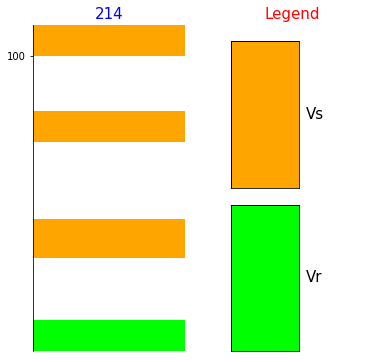

In [43]:
p.boreholes_3d[n].plot_log(repr_attribute=repr_att)

### 3D display of one borehole

In [44]:
at = 1
n = 5
repr_att = attributes[at]
list(p.boreholes_3d[n].legend_dict.keys())[at]

'benzène'

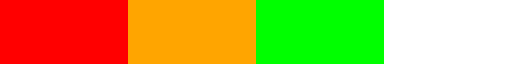

In [56]:
p.legend_dict[repr_att]['cmap']

In [46]:
p.boreholes_3d[n].geometry.data[at].array.array

array([0, 0, 0, 1])

In [47]:
p.boreholes_3d[n].plot_3d(repr_attribute=repr_att, str_annotations=False)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [48]:
p.boreholes_3d[n]._vtk.CELL_DATA_FIELD #.get_array #geometry.data[2].array.array

2

In [49]:
from core.visual import Borehole3D
from striplog import Interval, Component

In [50]:
intv = [Interval(0,1, components=[Component({'lithology':'sable'})]), 
        Interval(1,2, components=[Component({'lithology':'limon'})]),
        Interval(2,3, components=[Component({'lithology':'argile'})]),
        Interval(3,4, components=[Component({'lithology':'inconnu'})])]

In [51]:
bh_test = Borehole3D({'lithology':intv, 'sample':None}, repr_attribute='lithology', length=4, legend_dict=legend_dict)

Borehole geometry created successfully !



/home/yanathan/Projects/GSDMA/utils/visual.py:435: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect1 = patches.Rectangle((0, 0),


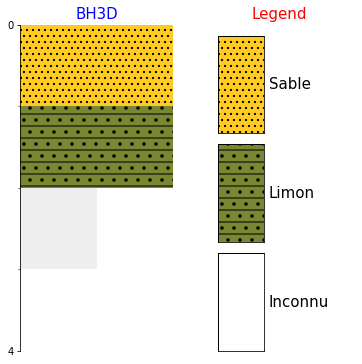

In [52]:
bh_test.plot_log()#3d()

In [53]:
p.boreholes_3d[n]._vtk

PolyData (0x7f7f787a00a0)
  N Cells:	208
  N Points:	800
  X Bounds:	1.529e+05, 1.529e+05
  Y Bounds:	1.226e+05, 1.226e+05
  Z Bounds:	9.705e+01, 1.013e+02
  N Arrays:	9

### Localization of project boreholes

### 3D display of project boreholes

In [54]:
pause

NameError: name 'pause' is not defined

In [ ]:
p.plot_3d(repr_attribute=repr_att, labels_size=15, bg_color=["royalblue", "aliceblue"], 
         window_size=(800, 600), verbose=True)